In [ ]:
!pip install segmentation_models

In [1]:
import tensorflow as tf
#import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from sklearn.model_selection import train_test_split
import albumentations as A
import glob

In [2]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Dropout, Conv2DTranspose, Multiply, ReLU, Add
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import models , layers
from keras.initializers import RandomNormal
from keras import backend as K
from tensorflow.keras.optimizers import Adam

In [3]:
from random import randint

In [4]:
def conv1b(inp,f):
    q = Conv2D(f, 1,(1,1),'valid', use_bias = False)(inp)
    return q

In [5]:
def conv3b(inp,f):
    e = Conv2D(f,3,(1,1),"same",use_bias = False)(inp)
    return e 

In [6]:
def resblock(inp,f):
    inp = Conv2D(f,1, use_bias = False)(inp)
    inp = Activation("LeakyReLU")(inp)
    inp = Conv2D(f, 3, strides=(1,1), padding ='same', use_bias = False , dilation_rate=(2, 2))(inp)
    inp = Activation("LeakyReLU")(inp)
    inp = Conv2D(f, 1, use_bias = False)(inp)
    inp = Activation("LeakyReLU")(inp)
    return inp

In [7]:
def irnn(inp):
    _,H,W,_ = tf.shape(inp)
    tleft = tf.identity(inp)
    tright = tf.identity(inp)
    tup = tf.identity(inp)
    tdown = tf.identity(inp)
    lw = Conv2D(32,1,(1,1),'valid', groups = 32)(inp)
    rw = Conv2D(32,1,(1,1),'valid', groups = 32)(inp)   
    uw = Conv2D(32,1,(1,1),'valid', groups = 32)(inp)
    dw = Conv2D(32,1,(1,1),'valid', groups = 32)(inp)
    tleftlist = []
    trightlist = []
    tuplist = []
    tdownlist = []
    tleftlist.append(tf.math.add(lw[:,:,:W,:], inp[:,:,:,:1]))
    tleft = tf.stack(tleftlist)
    tleft = tf.squeeze(tleft, axis = 0)
    trightlist.append(tf.math.add(rw[:,:,0:,:], inp[:,:,:W,:1]))
    tright = tf.stack(trightlist)
    tright = tf.squeeze(tright, axis = 0)
    tuplist.append(tf.math.add(uw[:,:H,:,:], inp[:,0:,:,:1]))
    tup = tf.stack(tuplist)
    tup = tf.squeeze(tup, axis = 0)
    tdownlist.append(tf.math.add(uw[:,0:,:,:], inp[:,:H,:,:1]))
    tdown = tf.stack(tdownlist)
    tdown = tf.squeeze(tdown, axis = 0)
    tleft = Activation("LeakyReLU")(tleft)
    tright = Activation("LeakyReLU")(tright)
    tup = Activation("LeakyReLU")(tup)
    tdown = Activation("LeakyReLU")(tdown)
    return tleft, tright, tup, tdown


In [8]:
def attention(x,f):
    inp = Conv2D(f, 3,(1,1),'same')(x)
    inp = Activation("LeakyReLU")(inp)
    inp = Conv2D(f, 3,(1,1),'same')(inp)
    inp = Activation("LeakyReLU")(inp)
    inp = Conv2D(f, 1,(1,1),'valid')(inp)
    inp = Activation("LeakyReLU")(inp)
    return inp

In [9]:
def SAM (x,f):
    attention_layer = attention(x,f)
    x = Conv2D(f,1,(1,1),'valid')(x)
    tleft, tright, tup, tdown = irnn(x)
    if attention:
        x1 = Multiply()([tup,attention_layer[:,:,:,0:1]])
        x2 = Multiply()([tright,attention_layer[:,:,:,1:2]])
        x3 = Multiply()([tdown,attention_layer[:,:,:,2:3]])
        x4 = Multiply()([tleft,attention_layer[:,:,:,3:4]])
    x = Concatenate()([x1,x2,x3,x4])
    x = Conv2D(f*4,1,(1,1),'valid')(x)
    x = irnn(x)
    if attention:
        x1 = Multiply()([tup,attention_layer[:,:,:,0:1]])
        x2 = Multiply()([tright,attention_layer[:,:,:,1:2]])
        x3 = Multiply()([tdown,attention_layer[:,:,:,2:3]])
        x4 = Multiply()([tleft,attention_layer[:,:,:,3:4]])
    x = Concatenate()([x1,x2,x3,x4])
    x = Conv2D(f*4,1,(1,1), 'valid')(x)
    x = Activation('LeakyReLU')(x)
    x = tf.keras.activations.sigmoid(conv1b(x,32))
    return x

In [10]:
def Spa_gen(image_shape):
    in_image = tf.keras.Input(image_shape, 1)
    
    x = conv3b(in_image,32)
    
    
    x = Activation("LeakyReLU")(x)
    
    res_block1= resblock(x,32)
    
    x = Activation('LeakyReLU')(res_block1+x)
    res_block2= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block2+x)
    
    
    res_block3= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block3+x)
    
    
    #print(tf.shape(x))
    attention1 = SAM(x,32) 
    
    res_block4= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block4*attention1+x)  
    res_block5= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block5*attention1+x)
    res_block6= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block6*attention1+x)
    
    attention2 = SAM(x,32)
    res_block7= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block7*attention2+x)
    res_block8= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block8*attention2+x)
    res_block9= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block9*attention2+x)
    attention3 = SAM(x,32)
    
    res_block10= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block10*attention3+x)
    
    res_block11= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block11*attention3+x)
    
    res_block12= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block1*attention3+x)
    
    attention4 = SAM(x,32)

    res_block13= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block13*attention4+x)
    
    res_block14= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block14*attention4+x)
    
    res_block15= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block15*attention4+x)
    
    res_block16= resblock(x,32)
    x = tf.keras.layers.LeakyReLU()(res_block16+x)
    
    res_block17= resblock(x,32)
    
    x = tf.keras.layers.LeakyReLU()(res_block17+x)
    x = Conv2D(3,3,(1,1),'same', use_bias = False)(x)
    
    
    return Model(in_image, x)

In [11]:
def discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    source_image = Input(shape=image_shape)
    gen_image = Input(shape=image_shape) #image produced from generator
    join = Concatenate()([source_image,gen_image]) #concatenate images channel-wise
    # Block 1: input is 512 x 512 x (3)
    x = layers.Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=init, name='conv_1')(join)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
    # Block 2: input is 256 x 256 x (64)
    x = layers.Conv2D(128, 4, 2, 'same', kernel_initializer=init, name='conv_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
    # Block 3: input is 64 x 64 x (128)
    x = layers.Conv2D(256, 4, 2, 'same', kernel_initializer=init, name='conv_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
    # Block 4: input is 32 x 32 x (256)
    x = layers.Conv2D(512, 4, 2, 'same', kernel_initializer=init, name='conv_4')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_4')(x)
    # Block 5: input is 16 x 16 x (512)
    outputs = layers.Conv2D(1, 4, 2, 'same', kernel_initializer=init, activation='sigmoid', name='conv_5')(x)
    # Output: 1 x 1 x 1
    #define model
    model = Model([source_image,gen_image], outputs)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [12]:
def call_GAN(g_model, d_model, image_shape):
    d_model.trainable = False
    sourc_image = Input(shape=image_shape) 
    gen_out = g_model(sourc_image)
    print(gen_out)
    dis_out = d_model([sourc_image, gen_out])
    model = Model(sourc_image, [dis_out, gen_out])
    opt = Adam(learning_rate=0.00002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [13]:
trainlistpath = '/kaggle/input/spagaan/RICE_DATASET/RICE1/train_list.txt'
trainlistn = os.path.join(trainlistpath)
trainlistlnk = open(trainlistpath)
trainlist = trainlistlnk.read()
trainlist = trainlist.split('\n')
del trainlist[-1]

In [ ]:
len(trainlist)

In [14]:
testlistpath = '/kaggle/input/spagaan/RICE_DATASET/RICE1/test_list.txt'
testlistn = os.path.join(testlistpath)
testlistlnk = open(testlistn)
testlist = testlistlnk.read()
testlist = testlist.split("\n")
del testlist[-1]

(512, 512, 3)


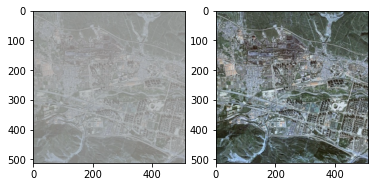

In [15]:
cloudypath = '/kaggle/input/spagaan/RICE_DATASET/RICE1/cloudy_image/'
groundtruthpath = '/kaggle/input/spagaan/RICE_DATASET/RICE1/ground_truth'
traincloud = [os.path.join(cloudypath,x) for x in trainlist]
traingroundtruth = [os.path.join(groundtruthpath,x) for x in trainlist]
pic = cv2.imread(traincloud[13])
pic1 = cv2.imread(traingroundtruth[13])
image_shape = pic1.shape
print(image_shape)
plt.subplot(1,2,1)
plt.imshow(pic)
plt.subplot(1,2,2)
plt.imshow(pic1)

In [16]:
def datapreprocesstest(c,g):
    #tc = []
    #tg = []
    fc = glob.glob(c)
    fg = glob.glob(g)
    #for f1 in fc:
    Im =cv2.imread(str(c)).astype(np.float32)
    Im = Im[np.newaxis, :, :, :]
        #tc.append(Im)
    #for f2 in fg:
    Ig = cv2.imread(str(g)).astype(np.float32)
    Ig = Ig[np.newaxis, :, :, :]
        #tg.append(Ig)    
    Imm = Im/255
    Igg = Ig/255
    #tc = Imm.transpose(2,0,1)
    #tg = Igg.transpose(2,0,1)
    
    return Imm, Igg

In [17]:
batchsize = 1
tg = []
tm = []
for i in range(400):
    
    dataset = datapreprocesstest(traincloud[i], traingroundtruth[i])
    tg.append(dataset[0])
    tm.append(dataset[1])

In [ ]:
len(tm)

In [18]:
def tf_dataset(traincloud, traingroundtruth,x):
    BUFFER_SIZE = 5000
    BATCH_SIZE = x
    print(tf.rank(traincloud))

# Batch and shuffle the data
    traincloud = tf.data.Dataset.from_tensor_slices(traincloud)
    print(traincloud)
    traingroundtruth = tf.data.Dataset.from_tensor_slices(traingroundtruth)
    print(traingroundtruth)
    return traincloud, traingroundtruth

In [ ]:
#dataset = tf_dataset(tg[0:1], tm[0:1], 1)

In [ ]:
#len(dataset[0])

In [ ]:
#tr = tf.data.Dataset.from_tensors(pic)
#tf.shape(tr)

In [ ]:
#img = img[np.newaxis, :,  :, :]

In [ ]:
#pic1 = pic[np.newaxis, :, :, :]
#pic1.shape

In [19]:
def generate_real_samples(dataset, n_samples, patch_shape):
    global X1
    global X2
    #X1 =0
    #X2 = 0
    trainA, trainB = dataset
    l = len(trainA)
    ix = randint(0, l)
    c = 0
    for i in trainA:
        if c == ix:
            X1 = i
        else:
            c+=1
    h =0
    for j in trainB:
        if h == ix:
            X2 = j
        else:
            h+=1
    
    
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [20]:
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [21]:
def summarize_performance(step, g_model, dataset, n_samples=3): 
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    print(len(X_realA))
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    X_realA = (X_realA + 1) / 2.0
    print(len(X_realA))
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    
    for i in range(1):
        plt.subplot(1, n_samples, 1)
        plt.axis('off')
        plt.imshow(X_realA[i])
        plt.show()
    
    for i in range(1):
        plt.subplot(1, n_samples, 2)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
        plt.show()
        
    for i in range(1):
        plt.subplot(1, n_samples, 3)
        plt.axis('off')
        plt.imshow(X_realB[i])
        plt.show()

    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
  
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [62]:
def train(d_model, g_model, gan_model, dataset, n_epochs=500, n_batch=1):
    n_patch = d_model.output_shape[1]
    trainA, trainB = dataset
    #bat_per_epo = int(len(trainA) / n_batch)
    #n_steps = bat_per_epo * n_epochs
    n_steps = 1500
    d_loss1_log = []
    d_loss2_log = []
    g_loss_log = []
    SSIM_log = []
    for i in range(n_steps):
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss1_log.append(d_loss1)
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d_loss2_log.append(d_loss2)
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        g_loss_log.append(g_loss)
        ssim = tf.image.ssim(X_realA, X_fakeB, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
        SSIM_log.append(ssim)

        plt.clf()
        plt.figure(figsize=(20,12))
        plt.title('Epoch:%d, d1[%.3f] d2[%.3f] g[%.3f] ssim[%.3f]' % (i+1, d_loss1, d_loss2, g_loss, ssim))
        plt.xlabel('Epoch', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.plot(d_loss1_log, 'r-', lw=2, label='d_loss1')
        plt.plot(d_loss2_log, 'b-', lw=1, label='d_loss2')
        plt.plot(g_loss_log, 'g-', lw=1, label='g_loss')
        
        plt.legend(prop={'size':16}, loc="upper right")
        #plt.show()
        #display.clear_output(wait=True)
        #display.display(plt.gcf())
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f] ssim[%.3f]' % (i+1, d_loss1, d_loss2, g_loss, ssim))
        if (i+1) % 50 == 0:
            plt.savefig('./loss_graph_%06d.jpg' % (i+1), bbox_inches='tight')
            summarize_performance(i, g_model, dataset)

In [59]:
 ssim2 = tf.image.ssim(aa, hh, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

tf.Tensor(5, shape=(), dtype=int32)
<TensorSliceDataset shapes: (1, 512, 512, 3), types: tf.float32>
<TensorSliceDataset shapes: (1, 512, 512, 3), types: tf.float32>
Dataset loaded
(<TensorSliceDataset shapes: (1, 512, 512, 3), types: tf.float32>, <TensorSliceDataset shapes: (1, 512, 512, 3), types: tf.float32>)
KerasTensor(type_spec=TensorSpec(shape=(1, 512, 512, 3), dtype=tf.float32, name=None), name='model_4/conv2d_225/Conv2D:0', description="created by layer 'model_4'")
>1, d1[0.236] d2[1.092] g[47.047] ssim[0.075]
>2, d1[0.146] d2[0.353] g[45.527] ssim[0.087]
>3, d1[0.102] d2[0.127] g[44.064] ssim[0.100]
>4, d1[0.122] d2[0.046] g[42.597] ssim[0.113]
>5, d1[0.124] d2[0.032] g[41.192] ssim[0.127]
>6, d1[0.030] d2[0.025] g[39.814] ssim[0.142]
>7, d1[0.020] d2[0.019] g[38.473] ssim[0.158]
>8, d1[0.014] d2[0.016] g[37.162] ssim[0.175]
>9, d1[0.012] d2[0.013] g[35.872] ssim[0.192]
>10, d1[0.010] d2[0.011] g[34.598] ssim[0.211]
>11, d1[0.009] d2[0.010] g[33.336] ssim[0.231]
>12, d1[0.008

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


>20, d1[0.004] d2[0.005] g[22.198] ssim[0.447]
>21, d1[0.004] d2[0.005] g[21.068] ssim[0.471]
>22, d1[0.004] d2[0.004] g[20.021] ssim[0.493]
>23, d1[0.004] d2[0.004] g[19.072] ssim[0.512]
>24, d1[0.004] d2[0.004] g[18.215] ssim[0.529]
>25, d1[0.003] d2[0.004] g[17.423] ssim[0.542]
>26, d1[0.003] d2[0.004] g[16.673] ssim[0.554]
>27, d1[0.003] d2[0.004] g[15.953] ssim[0.563]
>28, d1[0.003] d2[0.003] g[15.258] ssim[0.571]
>29, d1[0.003] d2[0.003] g[14.585] ssim[0.578]
>30, d1[0.003] d2[0.003] g[13.930] ssim[0.585]
>31, d1[0.003] d2[0.003] g[13.290] ssim[0.591]
>32, d1[0.003] d2[0.003] g[12.667] ssim[0.596]
>33, d1[0.003] d2[0.003] g[12.060] ssim[0.601]
>34, d1[0.003] d2[0.003] g[11.471] ssim[0.605]
>35, d1[0.003] d2[0.003] g[10.904] ssim[0.609]
>36, d1[0.003] d2[0.003] g[10.366] ssim[0.612]
>37, d1[0.003] d2[0.003] g[9.873] ssim[0.615]
>38, d1[0.003] d2[0.003] g[9.443] ssim[0.617]
>39, d1[0.003] d2[0.003] g[9.085] ssim[0.619]
>40, d1[0.003] d2[0.003] g[8.798] ssim[0.622]
>41, d1[0.003] d2

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

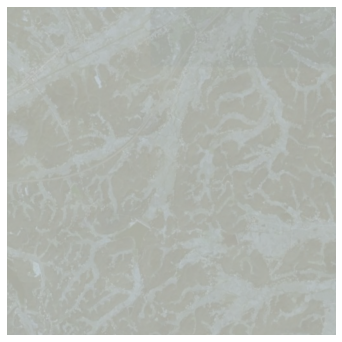

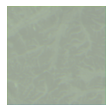

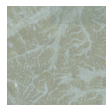

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


>Saved: plot_000050.png and model_000050.h5
>51, d1[0.002] d2[0.002] g[7.971] ssim[0.644]
>52, d1[0.002] d2[0.001] g[7.970] ssim[0.645]
>53, d1[0.002] d2[0.001] g[7.973] ssim[0.646]
>54, d1[0.002] d2[0.001] g[7.978] ssim[0.647]
>55, d1[0.001] d2[0.001] g[7.985] ssim[0.648]
>56, d1[0.001] d2[0.001] g[7.994] ssim[0.649]
>57, d1[0.001] d2[0.001] g[8.004] ssim[0.650]
>58, d1[0.001] d2[0.001] g[8.015] ssim[0.651]
>59, d1[0.001] d2[0.001] g[8.026] ssim[0.652]
>60, d1[0.001] d2[0.001] g[8.039] ssim[0.653]
>61, d1[0.001] d2[0.001] g[8.051] ssim[0.654]
>62, d1[0.001] d2[0.001] g[8.065] ssim[0.655]
>63, d1[0.001] d2[0.001] g[8.078] ssim[0.656]
>64, d1[0.001] d2[0.001] g[8.092] ssim[0.656]
>65, d1[0.001] d2[0.001] g[8.106] ssim[0.657]
>66, d1[0.001] d2[0.001] g[8.120] ssim[0.658]
>67, d1[0.001] d2[0.001] g[8.135] ssim[0.659]
>68, d1[0.001] d2[0.001] g[8.149] ssim[0.660]
>69, d1[0.001] d2[0.001] g[8.164] ssim[0.660]
>70, d1[0.001] d2[0.001] g[8.178] ssim[0.661]
>71, d1[0.001] d2[0.001] g[8.193] ss

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

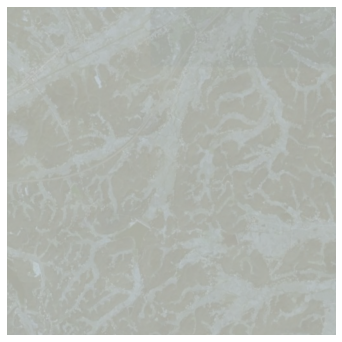

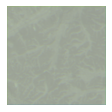

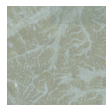

>Saved: plot_000100.png and model_000100.h5
>101, d1[0.000] d2[0.000] g[8.591] ssim[0.680]
>102, d1[0.000] d2[0.000] g[8.603] ssim[0.681]
>103, d1[0.000] d2[0.000] g[8.616] ssim[0.681]
>104, d1[0.000] d2[0.000] g[8.628] ssim[0.682]
>105, d1[0.000] d2[0.000] g[8.640] ssim[0.682]
>106, d1[0.000] d2[0.000] g[8.652] ssim[0.683]
>107, d1[0.000] d2[0.000] g[8.664] ssim[0.683]
>108, d1[0.000] d2[0.000] g[8.676] ssim[0.684]
>109, d1[0.000] d2[0.000] g[8.688] ssim[0.684]
>110, d1[0.000] d2[0.000] g[8.699] ssim[0.685]
>111, d1[0.000] d2[0.000] g[8.711] ssim[0.685]
>112, d1[0.000] d2[0.000] g[8.722] ssim[0.686]
>113, d1[0.000] d2[0.000] g[8.733] ssim[0.686]
>114, d1[0.000] d2[0.000] g[8.744] ssim[0.687]
>115, d1[0.000] d2[0.000] g[8.756] ssim[0.687]
>116, d1[0.000] d2[0.000] g[8.766] ssim[0.688]
>117, d1[0.000] d2[0.000] g[8.777] ssim[0.688]
>118, d1[0.000] d2[0.000] g[8.788] ssim[0.688]
>119, d1[0.000] d2[0.000] g[8.799] ssim[0.689]
>120, d1[0.000] d2[0.000] g[8.809] ssim[0.689]
>121, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

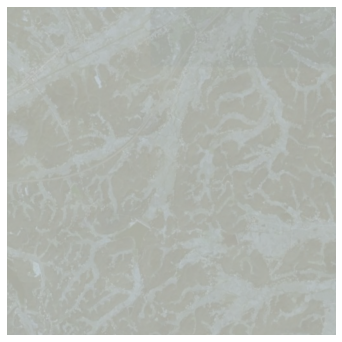

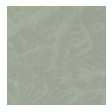

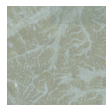

>Saved: plot_000150.png and model_000150.h5
>151, d1[0.000] d2[0.000] g[9.082] ssim[0.702]
>152, d1[0.000] d2[0.000] g[9.089] ssim[0.702]
>153, d1[0.000] d2[0.000] g[9.096] ssim[0.702]
>154, d1[0.000] d2[0.000] g[9.102] ssim[0.703]
>155, d1[0.000] d2[0.000] g[9.109] ssim[0.703]
>156, d1[0.000] d2[0.000] g[9.115] ssim[0.704]
>157, d1[0.000] d2[0.000] g[9.121] ssim[0.704]
>158, d1[0.000] d2[0.000] g[9.127] ssim[0.704]
>159, d1[0.000] d2[0.000] g[9.133] ssim[0.705]
>160, d1[0.000] d2[0.000] g[9.139] ssim[0.705]
>161, d1[0.000] d2[0.000] g[9.144] ssim[0.705]
>162, d1[0.000] d2[0.000] g[9.149] ssim[0.706]
>163, d1[0.000] d2[0.000] g[9.155] ssim[0.706]
>164, d1[0.000] d2[0.000] g[9.160] ssim[0.706]
>165, d1[0.000] d2[0.000] g[9.165] ssim[0.707]
>166, d1[0.000] d2[0.000] g[9.170] ssim[0.707]
>167, d1[0.000] d2[0.000] g[9.175] ssim[0.707]
>168, d1[0.000] d2[0.000] g[9.179] ssim[0.708]
>169, d1[0.000] d2[0.000] g[9.184] ssim[0.708]
>170, d1[0.000] d2[0.000] g[9.189] ssim[0.708]
>171, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

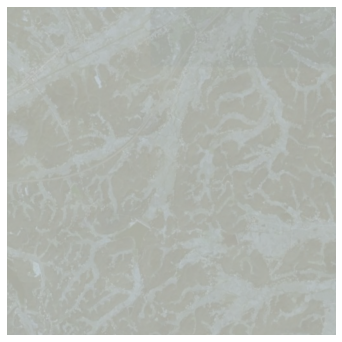

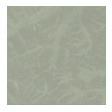

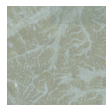

>Saved: plot_000200.png and model_000200.h5
>201, d1[0.000] d2[0.000] g[9.249] ssim[0.719]
>202, d1[0.000] d2[0.000] g[9.248] ssim[0.719]
>203, d1[0.000] d2[0.000] g[9.247] ssim[0.720]
>204, d1[0.000] d2[0.000] g[9.245] ssim[0.720]
>205, d1[0.000] d2[0.000] g[9.242] ssim[0.721]
>206, d1[0.000] d2[0.000] g[9.239] ssim[0.721]
>207, d1[0.000] d2[0.000] g[9.236] ssim[0.721]
>208, d1[0.000] d2[0.000] g[9.232] ssim[0.722]
>209, d1[0.000] d2[0.000] g[9.228] ssim[0.722]
>210, d1[0.000] d2[0.000] g[9.224] ssim[0.722]
>211, d1[0.000] d2[0.000] g[9.220] ssim[0.723]
>212, d1[0.000] d2[0.000] g[9.214] ssim[0.723]
>213, d1[0.000] d2[0.000] g[9.209] ssim[0.723]
>214, d1[0.000] d2[0.000] g[9.202] ssim[0.724]
>215, d1[0.000] d2[0.000] g[9.195] ssim[0.724]
>216, d1[0.000] d2[0.000] g[9.187] ssim[0.724]
>217, d1[0.000] d2[0.000] g[9.179] ssim[0.724]
>218, d1[0.000] d2[0.000] g[9.171] ssim[0.725]
>219, d1[0.000] d2[0.000] g[9.162] ssim[0.725]
>220, d1[0.000] d2[0.000] g[9.153] ssim[0.725]
>221, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

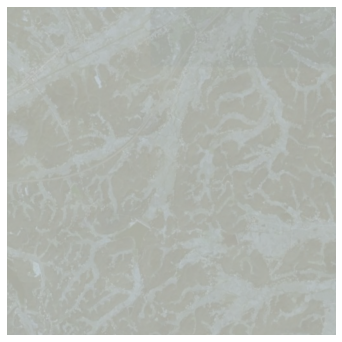

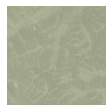

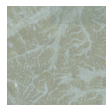

>Saved: plot_000250.png and model_000250.h5
>251, d1[0.000] d2[0.000] g[8.948] ssim[0.701]
>252, d1[0.000] d2[0.000] g[8.970] ssim[0.696]
>253, d1[0.000] d2[0.000] g[9.000] ssim[0.691]
>254, d1[0.000] d2[0.000] g[9.041] ssim[0.686]
>255, d1[0.000] d2[0.000] g[9.094] ssim[0.680]
>256, d1[0.000] d2[0.000] g[9.158] ssim[0.674]
>257, d1[0.000] d2[0.000] g[9.226] ssim[0.667]
>258, d1[0.000] d2[0.000] g[9.294] ssim[0.660]
>259, d1[0.000] d2[0.000] g[9.367] ssim[0.654]
>260, d1[0.000] d2[0.000] g[9.446] ssim[0.649]
>261, d1[0.000] d2[0.000] g[9.525] ssim[0.643]
>262, d1[0.000] d2[0.000] g[9.601] ssim[0.638]
>263, d1[0.000] d2[0.000] g[9.672] ssim[0.633]
>264, d1[0.000] d2[0.000] g[9.736] ssim[0.629]
>265, d1[0.000] d2[0.000] g[9.793] ssim[0.625]
>266, d1[0.000] d2[0.000] g[9.850] ssim[0.621]
>267, d1[0.000] d2[0.000] g[9.905] ssim[0.618]
>268, d1[0.000] d2[0.000] g[9.956] ssim[0.614]
>269, d1[0.000] d2[0.000] g[10.009] ssim[0.610]
>270, d1[0.000] d2[0.000] g[10.059] ssim[0.606]
>271, d1[0.000

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

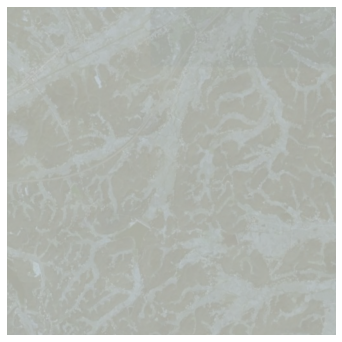

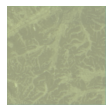

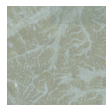

>Saved: plot_000300.png and model_000300.h5
>301, d1[0.000] d2[0.000] g[9.265] ssim[0.606]
>302, d1[0.000] d2[0.000] g[9.168] ssim[0.612]
>303, d1[0.000] d2[0.000] g[9.066] ssim[0.613]
>304, d1[0.000] d2[0.000] g[8.966] ssim[0.620]
>305, d1[0.000] d2[0.000] g[8.857] ssim[0.620]
>306, d1[0.000] d2[0.000] g[8.747] ssim[0.629]
>307, d1[0.000] d2[0.000] g[8.635] ssim[0.627]
>308, d1[0.000] d2[0.000] g[8.516] ssim[0.641]
>309, d1[0.000] d2[0.000] g[8.423] ssim[0.632]
>310, d1[0.000] d2[0.000] g[8.307] ssim[0.657]
>311, d1[0.000] d2[0.000] g[8.245] ssim[0.631]
>312, d1[0.000] d2[0.000] g[8.122] ssim[0.679]
>313, d1[0.000] d2[0.000] g[8.093] ssim[0.632]
>314, d1[0.000] d2[0.000] g[7.856] ssim[0.689]
>315, d1[0.000] d2[0.000] g[7.699] ssim[0.656]
>316, d1[0.000] d2[0.000] g[7.531] ssim[0.689]
>317, d1[0.000] d2[0.000] g[7.431] ssim[0.674]
>318, d1[0.000] d2[0.000] g[7.302] ssim[0.693]
>319, d1[0.000] d2[0.000] g[7.208] ssim[0.684]
>320, d1[0.000] d2[0.000] g[7.071] ssim[0.703]
>321, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

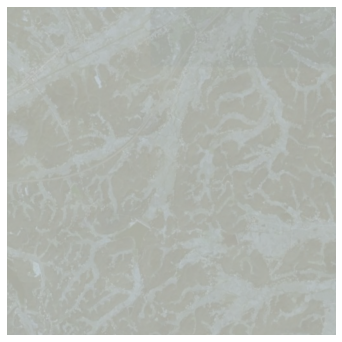

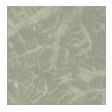

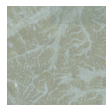

>Saved: plot_000350.png and model_000350.h5
>351, d1[0.000] d2[0.000] g[4.613] ssim[0.750]
>352, d1[0.000] d2[0.000] g[4.489] ssim[0.774]
>353, d1[0.000] d2[0.000] g[4.618] ssim[0.748]
>354, d1[0.000] d2[0.000] g[4.478] ssim[0.773]
>355, d1[0.000] d2[0.000] g[4.596] ssim[0.748]
>356, d1[0.000] d2[0.000] g[4.483] ssim[0.773]
>357, d1[0.000] d2[0.000] g[4.609] ssim[0.747]
>358, d1[0.000] d2[0.000] g[4.477] ssim[0.772]
>359, d1[0.000] d2[0.000] g[4.597] ssim[0.748]
>360, d1[0.000] d2[0.000] g[4.487] ssim[0.771]
>361, d1[0.000] d2[0.000] g[4.615] ssim[0.747]
>362, d1[0.000] d2[0.000] g[4.480] ssim[0.770]
>363, d1[0.000] d2[0.000] g[4.588] ssim[0.748]
>364, d1[0.000] d2[0.000] g[4.463] ssim[0.769]
>365, d1[0.000] d2[0.000] g[4.571] ssim[0.748]
>366, d1[0.000] d2[0.000] g[4.477] ssim[0.768]
>367, d1[0.000] d2[0.000] g[4.589] ssim[0.747]
>368, d1[0.000] d2[0.000] g[4.477] ssim[0.767]
>369, d1[0.000] d2[0.000] g[4.611] ssim[0.746]
>370, d1[0.000] d2[0.000] g[4.487] ssim[0.766]
>371, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

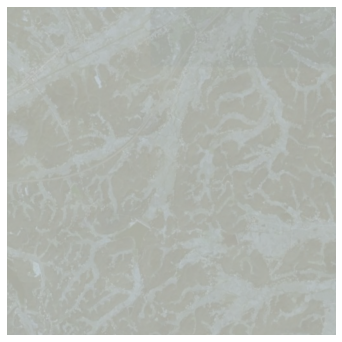

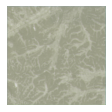

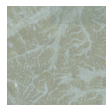

>Saved: plot_000400.png and model_000400.h5
>401, d1[0.000] d2[0.000] g[5.092] ssim[0.736]
>402, d1[0.000] d2[0.000] g[4.978] ssim[0.753]
>403, d1[0.000] d2[0.000] g[5.090] ssim[0.738]
>404, d1[0.000] d2[0.000] g[5.000] ssim[0.753]
>405, d1[0.000] d2[0.000] g[5.138] ssim[0.737]
>406, d1[0.000] d2[0.000] g[5.023] ssim[0.753]
>407, d1[0.000] d2[0.000] g[5.149] ssim[0.738]
>408, d1[0.000] d2[0.000] g[5.051] ssim[0.753]
>409, d1[0.000] d2[0.000] g[5.182] ssim[0.738]
>410, d1[0.000] d2[0.000] g[5.074] ssim[0.753]
>411, d1[0.000] d2[0.000] g[5.180] ssim[0.739]
>412, d1[0.000] d2[0.000] g[5.077] ssim[0.754]
>413, d1[0.000] d2[0.000] g[5.219] ssim[0.738]
>414, d1[0.000] d2[0.000] g[5.084] ssim[0.755]
>415, d1[0.000] d2[0.000] g[5.209] ssim[0.739]
>416, d1[0.000] d2[0.000] g[5.092] ssim[0.756]
>417, d1[0.000] d2[0.000] g[5.279] ssim[0.738]
>418, d1[0.000] d2[0.000] g[5.136] ssim[0.756]
>419, d1[0.000] d2[0.000] g[5.244] ssim[0.742]
>420, d1[0.000] d2[0.000] g[5.127] ssim[0.759]
>421, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

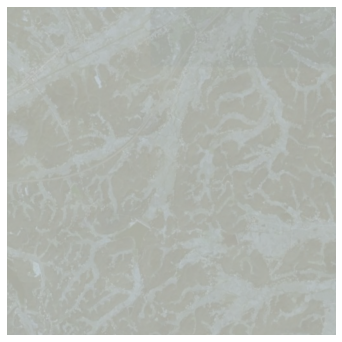

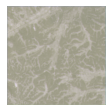

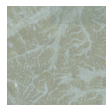

>Saved: plot_000450.png and model_000450.h5
>451, d1[0.000] d2[0.000] g[5.260] ssim[0.747]
>452, d1[0.000] d2[0.000] g[5.075] ssim[0.764]
>453, d1[0.000] d2[0.000] g[5.060] ssim[0.750]
>454, d1[0.000] d2[0.000] g[5.077] ssim[0.758]
>455, d1[0.000] d2[0.000] g[5.257] ssim[0.748]
>456, d1[0.000] d2[0.000] g[5.061] ssim[0.764]
>457, d1[0.000] d2[0.000] g[5.020] ssim[0.751]
>458, d1[0.000] d2[0.000] g[5.038] ssim[0.758]
>459, d1[0.000] d2[0.000] g[5.158] ssim[0.751]
>460, d1[0.000] d2[0.000] g[5.024] ssim[0.765]
>461, d1[0.000] d2[0.000] g[5.043] ssim[0.749]
>462, d1[0.000] d2[0.000] g[5.047] ssim[0.761]
>463, d1[0.000] d2[0.000] g[5.306] ssim[0.748]
>464, d1[0.000] d2[0.000] g[5.036] ssim[0.766]
>465, d1[0.000] d2[0.000] g[4.962] ssim[0.756]
>466, d1[0.000] d2[0.000] g[4.994] ssim[0.754]
>467, d1[0.000] d2[0.000] g[4.969] ssim[0.761]
>468, d1[0.000] d2[0.000] g[4.949] ssim[0.759]
>469, d1[0.000] d2[0.000] g[4.938] ssim[0.759]
>470, d1[0.000] d2[0.000] g[4.966] ssim[0.756]
>471, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

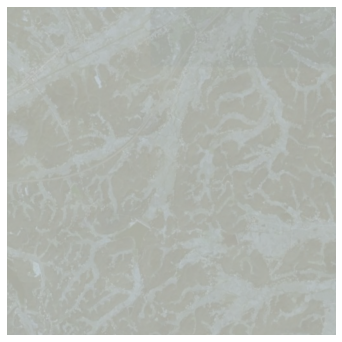

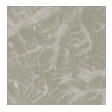

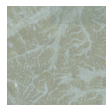

>Saved: plot_000500.png and model_000500.h5
>501, d1[0.000] d2[0.000] g[4.989] ssim[0.761]
>502, d1[0.000] d2[0.000] g[4.972] ssim[0.768]
>503, d1[0.000] d2[0.000] g[4.993] ssim[0.762]
>504, d1[0.000] d2[0.000] g[4.987] ssim[0.769]
>505, d1[0.000] d2[0.000] g[5.163] ssim[0.757]
>506, d1[0.000] d2[0.000] g[5.012] ssim[0.773]
>507, d1[0.000] d2[0.000] g[5.075] ssim[0.757]
>508, d1[0.000] d2[0.000] g[5.020] ssim[0.770]
>509, d1[0.000] d2[0.000] g[5.284] ssim[0.756]
>510, d1[0.000] d2[0.000] g[5.012] ssim[0.773]
>511, d1[0.000] d2[0.000] g[4.953] ssim[0.764]
>512, d1[0.000] d2[0.000] g[4.974] ssim[0.762]
>513, d1[0.000] d2[0.000] g[4.962] ssim[0.770]
>514, d1[0.000] d2[0.000] g[5.040] ssim[0.761]
>515, d1[0.000] d2[0.000] g[4.996] ssim[0.772]
>516, d1[0.000] d2[0.000] g[5.213] ssim[0.757]
>517, d1[0.000] d2[0.000] g[4.982] ssim[0.774]
>518, d1[0.000] d2[0.000] g[4.954] ssim[0.763]
>519, d1[0.000] d2[0.000] g[4.959] ssim[0.768]
>520, d1[0.000] d2[0.000] g[5.131] ssim[0.761]
>521, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

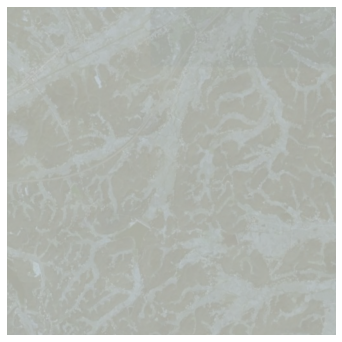

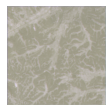

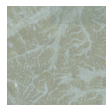

>Saved: plot_000550.png and model_000550.h5
>551, d1[0.000] d2[0.000] g[5.037] ssim[0.763]
>552, d1[0.000] d2[0.000] g[4.886] ssim[0.777]
>553, d1[0.000] d2[0.000] g[4.901] ssim[0.764]
>554, d1[0.000] d2[0.000] g[4.893] ssim[0.773]
>555, d1[0.000] d2[0.000] g[5.125] ssim[0.763]
>556, d1[0.000] d2[0.000] g[4.897] ssim[0.777]
>557, d1[0.000] d2[0.000] g[4.847] ssim[0.767]
>558, d1[0.000] d2[0.000] g[4.868] ssim[0.765]
>559, d1[0.000] d2[0.000] g[4.867] ssim[0.775]
>560, d1[0.000] d2[0.000] g[5.012] ssim[0.763]
>561, d1[0.000] d2[0.000] g[4.878] ssim[0.775]
>562, d1[0.000] d2[0.000] g[4.951] ssim[0.764]
>563, d1[0.000] d2[0.000] g[4.878] ssim[0.775]
>564, d1[0.000] d2[0.000] g[4.992] ssim[0.763]
>565, d1[0.000] d2[0.000] g[4.885] ssim[0.775]
>566, d1[0.000] d2[0.000] g[4.970] ssim[0.764]
>567, d1[0.000] d2[0.000] g[4.885] ssim[0.775]
>568, d1[0.000] d2[0.000] g[4.996] ssim[0.763]
>569, d1[0.000] d2[0.000] g[4.879] ssim[0.775]
>570, d1[0.000] d2[0.000] g[4.936] ssim[0.764]
>571, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

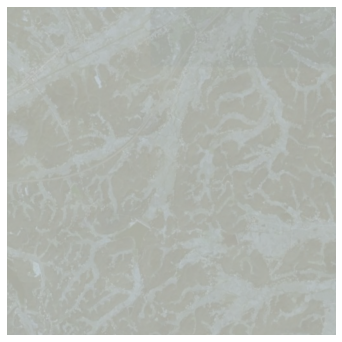

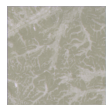

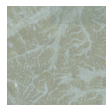

>Saved: plot_000600.png and model_000600.h5
>601, d1[0.000] d2[0.000] g[4.898] ssim[0.776]
>602, d1[0.000] d2[0.000] g[4.905] ssim[0.766]
>603, d1[0.000] d2[0.000] g[4.890] ssim[0.773]
>604, d1[0.000] d2[0.000] g[5.025] ssim[0.765]
>605, d1[0.000] d2[0.000] g[4.901] ssim[0.776]
>606, d1[0.000] d2[0.000] g[4.902] ssim[0.766]
>607, d1[0.000] d2[0.000] g[4.886] ssim[0.773]
>608, d1[0.000] d2[0.000] g[5.027] ssim[0.765]
>609, d1[0.000] d2[0.000] g[4.895] ssim[0.776]
>610, d1[0.000] d2[0.000] g[4.886] ssim[0.766]
>611, d1[0.000] d2[0.000] g[4.873] ssim[0.773]
>612, d1[0.000] d2[0.000] g[4.997] ssim[0.766]
>613, d1[0.000] d2[0.000] g[4.889] ssim[0.776]
>614, d1[0.000] d2[0.000] g[4.904] ssim[0.765]
>615, d1[0.000] d2[0.000] g[4.877] ssim[0.773]
>616, d1[0.000] d2[0.000] g[5.023] ssim[0.765]
>617, d1[0.000] d2[0.000] g[4.882] ssim[0.776]
>618, d1[0.000] d2[0.000] g[4.866] ssim[0.766]
>619, d1[0.000] d2[0.000] g[4.847] ssim[0.772]
>620, d1[0.000] d2[0.000] g[4.927] ssim[0.767]
>621, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

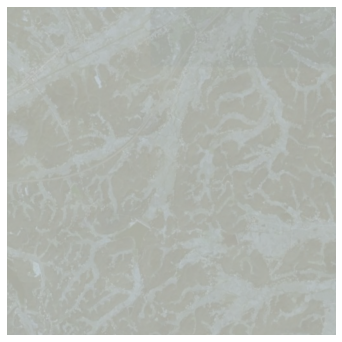

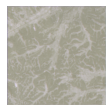

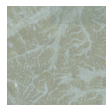

>Saved: plot_000650.png and model_000650.h5
>651, d1[0.000] d2[0.000] g[4.801] ssim[0.773]
>652, d1[0.000] d2[0.000] g[4.905] ssim[0.765]
>653, d1[0.000] d2[0.000] g[4.802] ssim[0.774]
>654, d1[0.000] d2[0.000] g[4.821] ssim[0.765]
>655, d1[0.000] d2[0.000] g[4.791] ssim[0.773]
>656, d1[0.000] d2[0.000] g[4.902] ssim[0.765]
>657, d1[0.000] d2[0.000] g[4.800] ssim[0.774]
>658, d1[0.000] d2[0.000] g[4.822] ssim[0.765]
>659, d1[0.000] d2[0.000] g[4.790] ssim[0.773]
>660, d1[0.000] d2[0.000] g[4.901] ssim[0.765]
>661, d1[0.000] d2[0.000] g[4.793] ssim[0.774]
>662, d1[0.000] d2[0.000] g[4.806] ssim[0.765]
>663, d1[0.000] d2[0.000] g[4.777] ssim[0.772]
>664, d1[0.000] d2[0.000] g[4.888] ssim[0.765]
>665, d1[0.000] d2[0.000] g[4.786] ssim[0.774]
>666, d1[0.000] d2[0.000] g[4.810] ssim[0.765]
>667, d1[0.000] d2[0.000] g[4.780] ssim[0.773]
>668, d1[0.000] d2[0.000] g[4.902] ssim[0.765]
>669, d1[0.000] d2[0.000] g[4.778] ssim[0.774]
>670, d1[0.000] d2[0.000] g[4.778] ssim[0.765]
>671, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

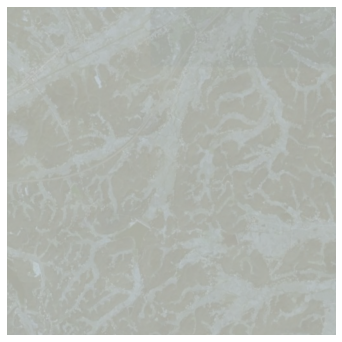

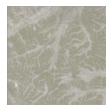

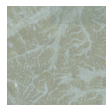

>Saved: plot_000700.png and model_000700.h5
>701, d1[0.000] d2[0.000] g[4.713] ssim[0.774]
>702, d1[0.000] d2[0.000] g[4.738] ssim[0.764]
>703, d1[0.000] d2[0.000] g[4.704] ssim[0.772]
>704, d1[0.000] d2[0.000] g[4.823] ssim[0.764]
>705, d1[0.000] d2[0.000] g[4.701] ssim[0.773]
>706, d1[0.000] d2[0.000] g[4.708] ssim[0.765]
>707, d1[0.000] d2[0.000] g[4.689] ssim[0.771]
>708, d1[0.000] d2[0.000] g[4.803] ssim[0.764]
>709, d1[0.000] d2[0.000] g[4.696] ssim[0.773]
>710, d1[0.000] d2[0.000] g[4.720] ssim[0.764]
>711, d1[0.000] d2[0.000] g[4.688] ssim[0.772]
>712, d1[0.000] d2[0.000] g[4.804] ssim[0.764]
>713, d1[0.000] d2[0.000] g[4.684] ssim[0.773]
>714, d1[0.000] d2[0.000] g[4.694] ssim[0.764]
>715, d1[0.000] d2[0.000] g[4.674] ssim[0.771]
>716, d1[0.000] d2[0.000] g[4.787] ssim[0.764]
>717, d1[0.000] d2[0.000] g[4.684] ssim[0.773]
>718, d1[0.000] d2[0.000] g[4.712] ssim[0.764]
>719, d1[0.000] d2[0.000] g[4.678] ssim[0.772]
>720, d1[0.000] d2[0.000] g[4.783] ssim[0.764]
>721, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

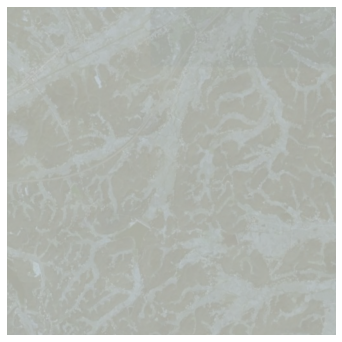

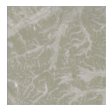

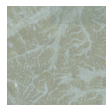

>Saved: plot_000750.png and model_000750.h5
>751, d1[0.000] d2[0.000] g[4.638] ssim[0.770]
>752, d1[0.000] d2[0.000] g[4.738] ssim[0.764]
>753, d1[0.000] d2[0.000] g[4.653] ssim[0.772]
>754, d1[0.000] d2[0.000] g[4.692] ssim[0.763]
>755, d1[0.000] d2[0.000] g[4.651] ssim[0.771]
>756, d1[0.000] d2[0.000] g[4.749] ssim[0.763]
>757, d1[0.000] d2[0.000] g[4.642] ssim[0.771]
>758, d1[0.000] d2[0.000] g[4.664] ssim[0.764]
>759, d1[0.000] d2[0.000] g[4.643] ssim[0.770]
>760, d1[0.000] d2[0.000] g[4.760] ssim[0.763]
>761, d1[0.000] d2[0.000] g[4.636] ssim[0.772]
>762, d1[0.000] d2[0.000] g[4.635] ssim[0.764]
>763, d1[0.000] d2[0.000] g[4.629] ssim[0.769]
>764, d1[0.000] d2[0.000] g[4.739] ssim[0.764]
>765, d1[0.000] d2[0.000] g[4.637] ssim[0.771]
>766, d1[0.000] d2[0.000] g[4.652] ssim[0.763]
>767, d1[0.000] d2[0.000] g[4.634] ssim[0.770]
>768, d1[0.000] d2[0.000] g[4.761] ssim[0.763]
>769, d1[0.000] d2[0.000] g[4.626] ssim[0.771]
>770, d1[0.000] d2[0.000] g[4.618] ssim[0.764]
>771, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

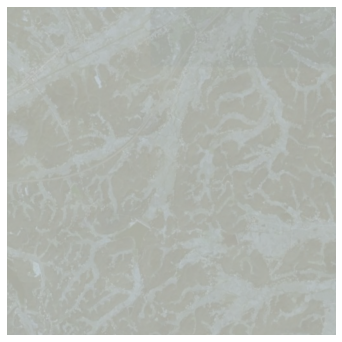

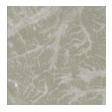

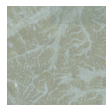

>Saved: plot_000800.png and model_000800.h5
>801, d1[0.000] d2[0.000] g[4.573] ssim[0.767]
>802, d1[0.000] d2[0.000] g[4.637] ssim[0.764]
>803, d1[0.000] d2[0.000] g[4.604] ssim[0.769]
>804, d1[0.000] d2[0.000] g[4.699] ssim[0.761]
>805, d1[0.000] d2[0.000] g[4.591] ssim[0.770]
>806, d1[0.000] d2[0.000] g[4.607] ssim[0.762]
>807, d1[0.000] d2[0.000] g[4.591] ssim[0.768]
>808, d1[0.000] d2[0.000] g[4.712] ssim[0.762]
>809, d1[0.000] d2[0.000] g[4.583] ssim[0.770]
>810, d1[0.000] d2[0.000] g[4.572] ssim[0.762]
>811, d1[0.000] d2[0.000] g[4.560] ssim[0.767]
>812, d1[0.000] d2[0.000] g[4.606] ssim[0.764]
>813, d1[0.000] d2[0.000] g[4.595] ssim[0.768]
>814, d1[0.000] d2[0.000] g[4.718] ssim[0.761]
>815, d1[0.000] d2[0.000] g[4.575] ssim[0.770]
>816, d1[0.000] d2[0.000] g[4.560] ssim[0.762]
>817, d1[0.000] d2[0.000] g[4.548] ssim[0.766]
>818, d1[0.000] d2[0.000] g[4.577] ssim[0.765]
>819, d1[0.000] d2[0.000] g[4.587] ssim[0.767]
>820, d1[0.000] d2[0.000] g[4.720] ssim[0.761]
>821, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

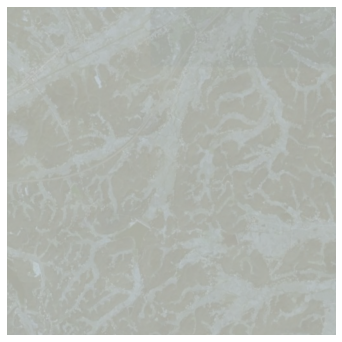

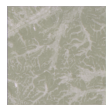

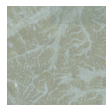

>Saved: plot_000850.png and model_000850.h5
>851, d1[0.000] d2[0.000] g[4.486] ssim[0.766]
>852, d1[0.000] d2[0.000] g[4.539] ssim[0.762]
>853, d1[0.000] d2[0.000] g[4.518] ssim[0.767]
>854, d1[0.000] d2[0.000] g[4.643] ssim[0.759]
>855, d1[0.000] d2[0.000] g[4.497] ssim[0.768]
>856, d1[0.000] d2[0.000] g[4.483] ssim[0.761]
>857, d1[0.000] d2[0.000] g[4.469] ssim[0.765]
>858, d1[0.000] d2[0.000] g[4.483] ssim[0.763]
>859, d1[0.000] d2[0.000] g[4.496] ssim[0.765]
>860, d1[0.000] d2[0.000] g[4.612] ssim[0.760]
>861, d1[0.000] d2[0.000] g[4.499] ssim[0.768]
>862, d1[0.000] d2[0.000] g[4.508] ssim[0.759]
>863, d1[0.000] d2[0.000] g[4.482] ssim[0.766]
>864, d1[0.000] d2[0.000] g[4.580] ssim[0.761]
>865, d1[0.000] d2[0.000] g[4.489] ssim[0.767]
>866, d1[0.000] d2[0.000] g[4.523] ssim[0.760]
>867, d1[0.000] d2[0.000] g[4.481] ssim[0.767]
>868, d1[0.000] d2[0.000] g[4.578] ssim[0.759]
>869, d1[0.000] d2[0.000] g[4.484] ssim[0.767]
>870, d1[0.000] d2[0.000] g[4.526] ssim[0.760]
>871, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

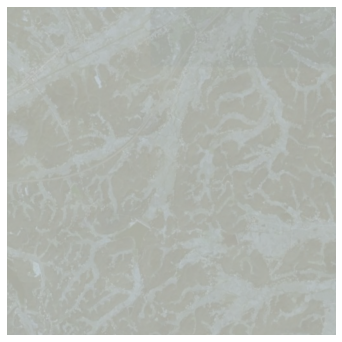

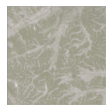

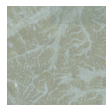

>Saved: plot_000900.png and model_000900.h5
>901, d1[0.000] d2[0.000] g[4.455] ssim[0.766]
>902, d1[0.000] d2[0.000] g[4.522] ssim[0.759]
>903, d1[0.000] d2[0.000] g[4.449] ssim[0.766]
>904, d1[0.000] d2[0.000] g[4.497] ssim[0.759]
>905, d1[0.000] d2[0.000] g[4.449] ssim[0.766]
>906, d1[0.000] d2[0.000] g[4.530] ssim[0.758]
>907, d1[0.000] d2[0.000] g[4.440] ssim[0.766]
>908, d1[0.000] d2[0.000] g[4.469] ssim[0.759]
>909, d1[0.000] d2[0.000] g[4.436] ssim[0.765]
>910, d1[0.000] d2[0.000] g[4.535] ssim[0.759]
>911, d1[0.000] d2[0.000] g[4.432] ssim[0.766]
>912, d1[0.000] d2[0.000] g[4.445] ssim[0.759]
>913, d1[0.000] d2[0.000] g[4.416] ssim[0.765]
>914, d1[0.000] d2[0.000] g[4.503] ssim[0.759]
>915, d1[0.000] d2[0.000] g[4.423] ssim[0.766]
>916, d1[0.000] d2[0.000] g[4.470] ssim[0.758]
>917, d1[0.000] d2[0.000] g[4.421] ssim[0.765]
>918, d1[0.000] d2[0.000] g[4.501] ssim[0.758]
>919, d1[0.000] d2[0.000] g[4.415] ssim[0.765]
>920, d1[0.000] d2[0.000] g[4.449] ssim[0.758]
>921, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

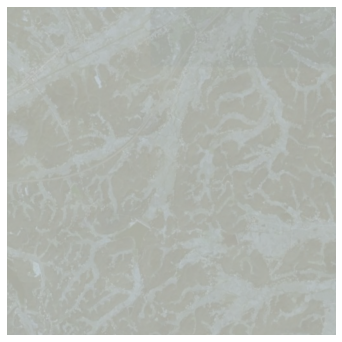

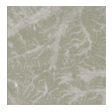

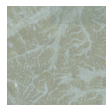

>Saved: plot_000950.png and model_000950.h5
>951, d1[0.000] d2[0.000] g[4.400] ssim[0.764]
>952, d1[0.000] d2[0.000] g[4.458] ssim[0.757]
>953, d1[0.000] d2[0.000] g[4.404] ssim[0.764]
>954, d1[0.000] d2[0.000] g[4.472] ssim[0.756]
>955, d1[0.000] d2[0.000] g[4.397] ssim[0.764]
>956, d1[0.000] d2[0.000] g[4.441] ssim[0.757]
>957, d1[0.000] d2[0.000] g[4.400] ssim[0.764]
>958, d1[0.000] d2[0.000] g[4.482] ssim[0.756]
>959, d1[0.000] d2[0.000] g[4.397] ssim[0.764]
>960, d1[0.000] d2[0.000] g[4.426] ssim[0.757]
>961, d1[0.000] d2[0.000] g[4.400] ssim[0.763]
>962, d1[0.000] d2[0.000] g[4.497] ssim[0.756]
>963, d1[0.000] d2[0.000] g[4.392] ssim[0.764]
>964, d1[0.000] d2[0.000] g[4.401] ssim[0.757]
>965, d1[0.000] d2[0.000] g[4.384] ssim[0.763]
>966, d1[0.000] d2[0.000] g[4.464] ssim[0.757]
>967, d1[0.000] d2[0.000] g[4.408] ssim[0.763]
>968, d1[0.000] d2[0.000] g[4.480] ssim[0.756]
>969, d1[0.000] d2[0.000] g[4.390] ssim[0.764]
>970, d1[0.000] d2[0.000] g[4.415] ssim[0.756]
>971, d1[0.000] 

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

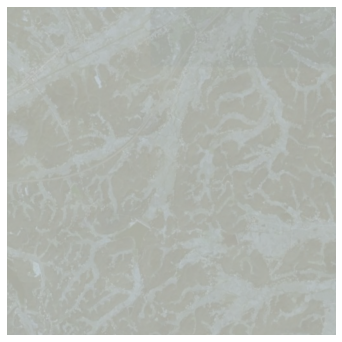

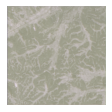

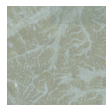

>Saved: plot_001000.png and model_001000.h5
>1001, d1[0.000] d2[0.000] g[4.402] ssim[0.761]
>1002, d1[0.000] d2[0.000] g[4.502] ssim[0.754]
>1003, d1[0.000] d2[0.000] g[4.395] ssim[0.762]
>1004, d1[0.000] d2[0.000] g[4.401] ssim[0.755]
>1005, d1[0.000] d2[0.000] g[4.388] ssim[0.761]
>1006, d1[0.000] d2[0.000] g[4.475] ssim[0.754]
>1007, d1[0.000] d2[0.000] g[4.400] ssim[0.762]
>1008, d1[0.000] d2[0.000] g[4.442] ssim[0.754]
>1009, d1[0.000] d2[0.000] g[4.404] ssim[0.761]
>1010, d1[0.000] d2[0.000] g[4.490] ssim[0.753]
>1011, d1[0.000] d2[0.000] g[4.390] ssim[0.762]
>1012, d1[0.000] d2[0.000] g[4.406] ssim[0.754]
>1013, d1[0.000] d2[0.000] g[4.390] ssim[0.761]
>1014, d1[0.000] d2[0.000] g[4.485] ssim[0.753]
>1015, d1[0.000] d2[0.000] g[4.397] ssim[0.761]
>1016, d1[0.000] d2[0.000] g[4.424] ssim[0.754]
>1017, d1[0.000] d2[0.000] g[4.394] ssim[0.761]
>1018, d1[0.000] d2[0.000] g[4.481] ssim[0.753]
>1019, d1[0.000] d2[0.000] g[4.397] ssim[0.761]
>1020, d1[0.000] d2[0.000] g[4.432] ssim[0.7

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

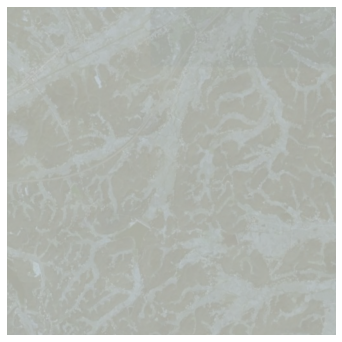

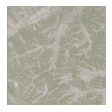

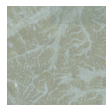

>Saved: plot_001050.png and model_001050.h5
>1051, d1[0.000] d2[0.000] g[4.388] ssim[0.759]
>1052, d1[0.000] d2[0.000] g[4.421] ssim[0.752]
>1053, d1[0.000] d2[0.000] g[4.390] ssim[0.759]
>1054, d1[0.000] d2[0.000] g[4.481] ssim[0.751]
>1055, d1[0.000] d2[0.000] g[4.390] ssim[0.759]
>1056, d1[0.000] d2[0.000] g[4.414] ssim[0.752]
>1057, d1[0.000] d2[0.000] g[4.391] ssim[0.758]
>1058, d1[0.000] d2[0.000] g[4.478] ssim[0.751]
>1059, d1[0.000] d2[0.000] g[4.396] ssim[0.759]
>1060, d1[0.000] d2[0.000] g[4.429] ssim[0.751]
>1061, d1[0.000] d2[0.000] g[4.398] ssim[0.758]
>1062, d1[0.000] d2[0.000] g[4.487] ssim[0.751]
>1063, d1[0.000] d2[0.000] g[4.400] ssim[0.759]
>1064, d1[0.000] d2[0.000] g[4.427] ssim[0.751]
>1065, d1[0.000] d2[0.000] g[4.400] ssim[0.758]
>1066, d1[0.000] d2[0.000] g[4.486] ssim[0.751]
>1067, d1[0.000] d2[0.000] g[4.403] ssim[0.759]
>1068, d1[0.000] d2[0.000] g[4.435] ssim[0.750]
>1069, d1[0.000] d2[0.000] g[4.404] ssim[0.758]
>1070, d1[0.000] d2[0.000] g[4.488] ssim[0.7

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

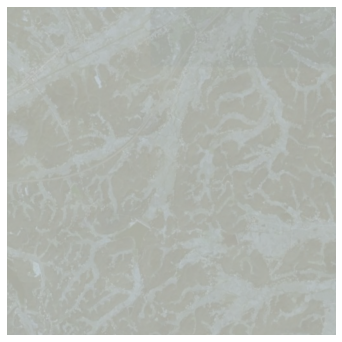

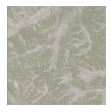

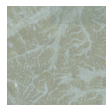

>Saved: plot_001100.png and model_001100.h5
>1101, d1[0.000] d2[0.000] g[4.424] ssim[0.756]
>1102, d1[0.000] d2[0.000] g[4.505] ssim[0.749]
>1103, d1[0.000] d2[0.000] g[4.435] ssim[0.757]
>1104, d1[0.000] d2[0.000] g[4.477] ssim[0.749]
>1105, d1[0.000] d2[0.000] g[4.438] ssim[0.756]
>1106, d1[0.000] d2[0.000] g[4.522] ssim[0.748]
>1107, d1[0.000] d2[0.000] g[4.425] ssim[0.757]
>1108, d1[0.000] d2[0.000] g[4.440] ssim[0.749]
>1109, d1[0.000] d2[0.000] g[4.424] ssim[0.756]
>1110, d1[0.000] d2[0.000] g[4.503] ssim[0.749]
>1111, d1[0.000] d2[0.000] g[4.435] ssim[0.756]
>1112, d1[0.000] d2[0.000] g[4.478] ssim[0.749]
>1113, d1[0.000] d2[0.000] g[4.438] ssim[0.756]
>1114, d1[0.000] d2[0.000] g[4.519] ssim[0.748]
>1115, d1[0.000] d2[0.000] g[4.433] ssim[0.756]
>1116, d1[0.000] d2[0.000] g[4.458] ssim[0.749]
>1117, d1[0.000] d2[0.000] g[4.435] ssim[0.755]
>1118, d1[0.000] d2[0.000] g[4.516] ssim[0.748]
>1119, d1[0.000] d2[0.000] g[4.434] ssim[0.756]
>1120, d1[0.000] d2[0.000] g[4.464] ssim[0.7

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

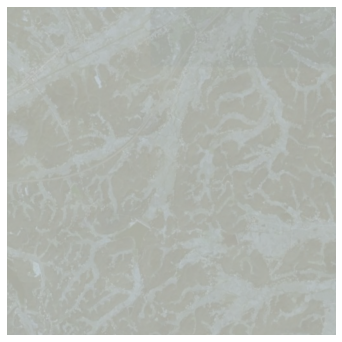

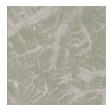

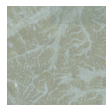

>Saved: plot_001150.png and model_001150.h5
>1151, d1[0.000] d2[0.000] g[4.448] ssim[0.754]
>1152, d1[0.000] d2[0.000] g[4.508] ssim[0.747]
>1153, d1[0.000] d2[0.000] g[4.453] ssim[0.754]
>1154, d1[0.000] d2[0.000] g[4.514] ssim[0.747]
>1155, d1[0.000] d2[0.000] g[4.447] ssim[0.754]
>1156, d1[0.000] d2[0.000] g[4.490] ssim[0.747]
>1157, d1[0.000] d2[0.000] g[4.448] ssim[0.754]
>1158, d1[0.000] d2[0.000] g[4.520] ssim[0.747]
>1159, d1[0.000] d2[0.000] g[4.446] ssim[0.754]
>1160, d1[0.000] d2[0.000] g[4.483] ssim[0.747]
>1161, d1[0.000] d2[0.000] g[4.445] ssim[0.753]
>1162, d1[0.000] d2[0.000] g[4.522] ssim[0.746]
>1163, d1[0.000] d2[0.000] g[4.444] ssim[0.754]
>1164, d1[0.000] d2[0.000] g[4.477] ssim[0.747]
>1165, d1[0.000] d2[0.000] g[4.444] ssim[0.753]
>1166, d1[0.000] d2[0.000] g[4.523] ssim[0.746]
>1167, d1[0.000] d2[0.000] g[4.441] ssim[0.753]
>1168, d1[0.000] d2[0.000] g[4.469] ssim[0.747]
>1169, d1[0.000] d2[0.000] g[4.445] ssim[0.753]
>1170, d1[0.000] d2[0.000] g[4.531] ssim[0.7

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

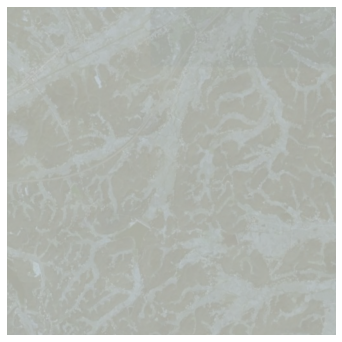

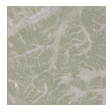

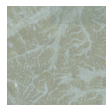

>Saved: plot_001200.png and model_001200.h5
>1201, d1[0.000] d2[0.000] g[4.443] ssim[0.751]
>1202, d1[0.000] d2[0.000] g[4.511] ssim[0.745]
>1203, d1[0.000] d2[0.000] g[4.449] ssim[0.752]
>1204, d1[0.000] d2[0.000] g[4.495] ssim[0.745]
>1205, d1[0.000] d2[0.000] g[4.446] ssim[0.751]
>1206, d1[0.000] d2[0.000] g[4.507] ssim[0.745]
>1207, d1[0.000] d2[0.000] g[4.448] ssim[0.751]
>1208, d1[0.000] d2[0.000] g[4.494] ssim[0.745]
>1209, d1[0.000] d2[0.000] g[4.444] ssim[0.751]
>1210, d1[0.000] d2[0.000] g[4.503] ssim[0.745]
>1211, d1[0.000] d2[0.000] g[4.446] ssim[0.751]
>1212, d1[0.000] d2[0.000] g[4.496] ssim[0.745]
>1213, d1[0.000] d2[0.000] g[4.449] ssim[0.751]
>1214, d1[0.000] d2[0.000] g[4.514] ssim[0.745]
>1215, d1[0.000] d2[0.000] g[4.448] ssim[0.751]
>1216, d1[0.000] d2[0.000] g[4.488] ssim[0.745]
>1217, d1[0.000] d2[0.000] g[4.450] ssim[0.750]
>1218, d1[0.000] d2[0.000] g[4.524] ssim[0.745]
>1219, d1[0.000] d2[0.000] g[4.451] ssim[0.751]
>1220, d1[0.000] d2[0.000] g[4.485] ssim[0.7

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

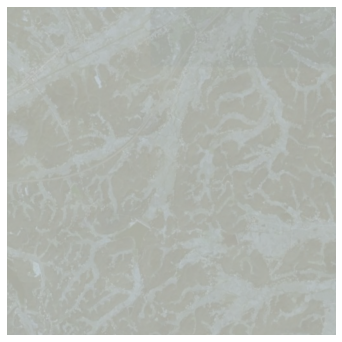

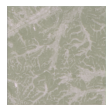

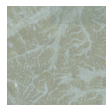

>Saved: plot_001250.png and model_001250.h5
>1251, d1[0.000] d2[0.000] g[4.460] ssim[0.750]
>1252, d1[0.000] d2[0.000] g[4.459] ssim[0.744]
>1253, d1[0.000] d2[0.000] g[4.459] ssim[0.748]
>1254, d1[0.000] d2[0.000] g[4.531] ssim[0.744]
>1255, d1[0.000] d2[0.000] g[4.472] ssim[0.750]
>1256, d1[0.000] d2[0.000] g[4.534] ssim[0.742]
>1257, d1[0.000] d2[0.000] g[4.479] ssim[0.749]
>1258, d1[0.000] d2[0.000] g[4.573] ssim[0.743]
>1259, d1[0.000] d2[0.000] g[4.462] ssim[0.750]
>1260, d1[0.000] d2[0.000] g[4.466] ssim[0.744]
>1261, d1[0.000] d2[0.000] g[4.466] ssim[0.749]
>1262, d1[0.000] d2[0.000] g[4.559] ssim[0.743]
>1263, d1[0.000] d2[0.000] g[4.476] ssim[0.750]
>1264, d1[0.000] d2[0.000] g[4.508] ssim[0.743]
>1265, d1[0.000] d2[0.000] g[4.485] ssim[0.749]
>1266, d1[0.000] d2[0.000] g[4.603] ssim[0.742]
>1267, d1[0.000] d2[0.000] g[4.470] ssim[0.750]
>1268, d1[0.000] d2[0.000] g[4.458] ssim[0.744]
>1269, d1[0.000] d2[0.000] g[4.456] ssim[0.747]
>1270, d1[0.000] d2[0.000] g[4.486] ssim[0.7

2023-02-08 06:20:23.078543: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1272, d1[0.000] d2[0.000] g[4.581] ssim[0.742]
>1273, d1[0.000] d2[0.000] g[4.473] ssim[0.749]
>1274, d1[0.000] d2[0.000] g[4.502] ssim[0.743]
>1275, d1[0.000] d2[0.000] g[4.474] ssim[0.749]
>1276, d1[0.000] d2[0.000] g[4.569] ssim[0.741]
>1277, d1[0.000] d2[0.000] g[4.466] ssim[0.750]
>1278, d1[0.000] d2[0.000] g[4.493] ssim[0.742]
>1279, d1[0.000] d2[0.000] g[4.468] ssim[0.748]
>1280, d1[0.000] d2[0.000] g[4.562] ssim[0.742]
>1281, d1[0.000] d2[0.000] g[4.461] ssim[0.749]
>1282, d1[0.000] d2[0.000] g[4.483] ssim[0.742]
>1283, d1[0.000] d2[0.000] g[4.462] ssim[0.748]
>1284, d1[0.000] d2[0.000] g[4.558] ssim[0.742]
>1285, d1[0.000] d2[0.000] g[4.464] ssim[0.749]
>1286, d1[0.000] d2[0.000] g[4.491] ssim[0.741]
>1287, d1[0.000] d2[0.000] g[4.468] ssim[0.748]
>1288, d1[0.000] d2[0.000] g[4.575] ssim[0.741]
>1289, d1[0.000] d2[0.000] g[4.463] ssim[0.749]
>1290, d1[0.000] d2[0.000] g[4.468] ssim[0.742]
>1291, d1[0.000] d2[0.000] g[4.460] ssim[0.747]
>1292, d1[0.000] d2[0.000] g[4.539] ssim

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

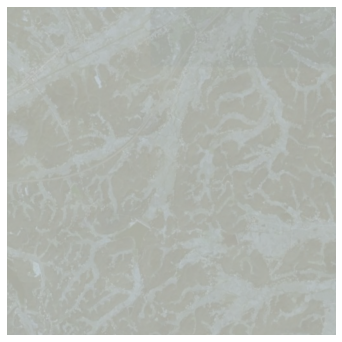

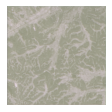

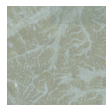

>Saved: plot_001300.png and model_001300.h5
>1301, d1[0.000] d2[0.000] g[4.466] ssim[0.748]
>1302, d1[0.000] d2[0.000] g[4.469] ssim[0.742]
>1303, d1[0.000] d2[0.000] g[4.464] ssim[0.746]
>1304, d1[0.000] d2[0.000] g[4.540] ssim[0.741]
>1305, d1[0.000] d2[0.000] g[4.478] ssim[0.748]
>1306, d1[0.000] d2[0.000] g[4.548] ssim[0.739]
>1307, d1[0.000] d2[0.000] g[4.476] ssim[0.747]
>1308, d1[0.000] d2[0.000] g[4.550] ssim[0.740]
>1309, d1[0.000] d2[0.000] g[4.478] ssim[0.748]
>1310, d1[0.000] d2[0.000] g[4.534] ssim[0.740]
>1311, d1[0.000] d2[0.000] g[4.485] ssim[0.747]
>1312, d1[0.000] d2[0.000] g[4.586] ssim[0.739]
>1313, d1[0.000] d2[0.000] g[4.477] ssim[0.747]
>1314, d1[0.000] d2[0.000] g[4.499] ssim[0.741]
>1315, d1[0.000] d2[0.000] g[4.480] ssim[0.746]
>1316, d1[0.000] d2[0.000] g[4.572] ssim[0.739]
>1317, d1[0.000] d2[0.000] g[4.484] ssim[0.747]
>1318, d1[0.000] d2[0.000] g[4.534] ssim[0.739]
>1319, d1[0.000] d2[0.000] g[4.490] ssim[0.746]
>1320, d1[0.000] d2[0.000] g[4.595] ssim[0.7

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

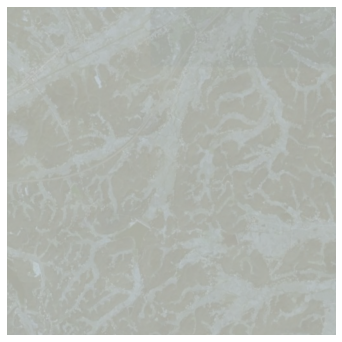

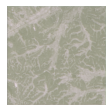

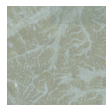

>Saved: plot_001350.png and model_001350.h5
>1351, d1[0.000] d2[0.000] g[4.511] ssim[0.744]
>1352, d1[0.000] d2[0.000] g[4.589] ssim[0.737]
>1353, d1[0.000] d2[0.000] g[4.500] ssim[0.744]
>1354, d1[0.000] d2[0.000] g[4.531] ssim[0.737]
>1355, d1[0.000] d2[0.000] g[4.515] ssim[0.743]
>1356, d1[0.000] d2[0.000] g[4.628] ssim[0.736]
>1357, d1[0.000] d2[0.000] g[4.497] ssim[0.744]
>1358, d1[0.000] d2[0.000] g[4.493] ssim[0.738]
>1359, d1[0.000] d2[0.000] g[4.495] ssim[0.742]
>1360, d1[0.000] d2[0.000] g[4.567] ssim[0.737]
>1361, d1[0.000] d2[0.000] g[4.511] ssim[0.744]
>1362, d1[0.000] d2[0.000] g[4.595] ssim[0.736]
>1363, d1[0.000] d2[0.000] g[4.508] ssim[0.743]
>1364, d1[0.000] d2[0.000] g[4.561] ssim[0.736]
>1365, d1[0.000] d2[0.000] g[4.514] ssim[0.743]
>1366, d1[0.000] d2[0.000] g[4.596] ssim[0.735]
>1367, d1[0.000] d2[0.000] g[4.516] ssim[0.743]
>1368, d1[0.000] d2[0.000] g[4.572] ssim[0.736]
>1369, d1[0.000] d2[0.000] g[4.518] ssim[0.743]
>1370, d1[0.000] d2[0.000] g[4.594] ssim[0.7

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

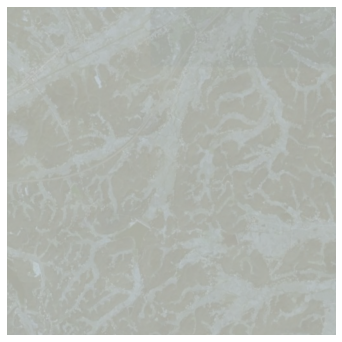

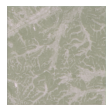

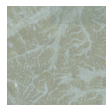

>Saved: plot_001400.png and model_001400.h5
>1401, d1[0.000] d2[0.000] g[4.553] ssim[0.740]
>1402, d1[0.000] d2[0.000] g[4.608] ssim[0.733]
>1403, d1[0.000] d2[0.000] g[4.553] ssim[0.740]
>1404, d1[0.000] d2[0.000] g[4.619] ssim[0.732]
>1405, d1[0.000] d2[0.000] g[4.553] ssim[0.740]
>1406, d1[0.000] d2[0.000] g[4.613] ssim[0.733]
>1407, d1[0.000] d2[0.000] g[4.551] ssim[0.740]
>1408, d1[0.000] d2[0.000] g[4.614] ssim[0.732]
>1409, d1[0.000] d2[0.000] g[4.554] ssim[0.739]
>1410, d1[0.000] d2[0.000] g[4.623] ssim[0.732]
>1411, d1[0.000] d2[0.000] g[4.557] ssim[0.739]
>1412, d1[0.000] d2[0.000] g[4.618] ssim[0.732]
>1413, d1[0.000] d2[0.000] g[4.562] ssim[0.739]
>1414, d1[0.000] d2[0.000] g[4.633] ssim[0.731]
>1415, d1[0.000] d2[0.000] g[4.562] ssim[0.739]
>1416, d1[0.000] d2[0.000] g[4.621] ssim[0.731]
>1417, d1[0.000] d2[0.000] g[4.565] ssim[0.739]
>1418, d1[0.000] d2[0.000] g[4.639] ssim[0.731]
>1419, d1[0.000] d2[0.000] g[4.563] ssim[0.739]
>1420, d1[0.000] d2[0.000] g[4.616] ssim[0.7

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

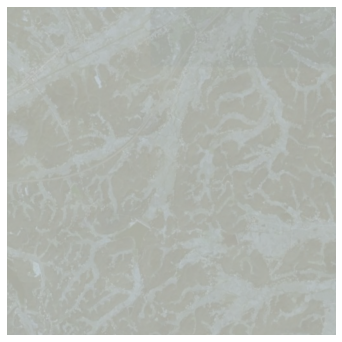

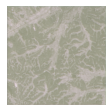

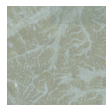

>Saved: plot_001450.png and model_001450.h5
>1451, d1[0.000] d2[0.000] g[4.575] ssim[0.736]
>1452, d1[0.000] d2[0.000] g[4.601] ssim[0.729]
>1453, d1[0.000] d2[0.000] g[4.580] ssim[0.735]
>1454, d1[0.000] d2[0.000] g[4.669] ssim[0.727]
>1455, d1[0.000] d2[0.000] g[4.577] ssim[0.736]
>1456, d1[0.000] d2[0.000] g[4.605] ssim[0.729]
>1457, d1[0.000] d2[0.000] g[4.584] ssim[0.735]
>1458, d1[0.000] d2[0.000] g[4.676] ssim[0.727]
>1459, d1[0.000] d2[0.000] g[4.580] ssim[0.736]
>1460, d1[0.000] d2[0.000] g[4.604] ssim[0.728]
>1461, d1[0.000] d2[0.000] g[4.581] ssim[0.734]
>1462, d1[0.000] d2[0.000] g[4.669] ssim[0.727]
>1463, d1[0.000] d2[0.000] g[4.582] ssim[0.735]
>1464, d1[0.000] d2[0.000] g[4.615] ssim[0.727]
>1465, d1[0.000] d2[0.000] g[4.585] ssim[0.734]
>1466, d1[0.000] d2[0.000] g[4.668] ssim[0.726]
>1467, d1[0.000] d2[0.000] g[4.587] ssim[0.735]
>1468, d1[0.000] d2[0.000] g[4.628] ssim[0.727]
>1469, d1[0.000] d2[0.000] g[4.588] ssim[0.734]
>1470, d1[0.000] d2[0.000] g[4.668] ssim[0.7

<Figure size 432x288 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

<Figure size 1440x864 with 0 Axes>

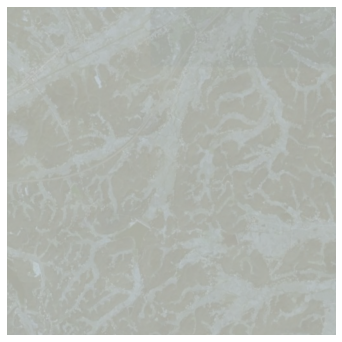

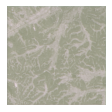

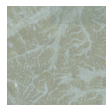

>Saved: plot_001500.png and model_001500.h5


In [63]:
dataset = tf_dataset(tg,tm,1)
print("Dataset loaded")
print(dataset)
#image_shape = 
image_shape = (512,512,3)
d_model = discriminator(image_shape)

g_model = Spa_gen(image_shape)


gan_model = call_GAN(g_model, d_model, image_shape)

train(d_model, g_model, gan_model, dataset, n_epochs=1500)

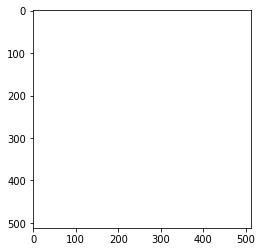

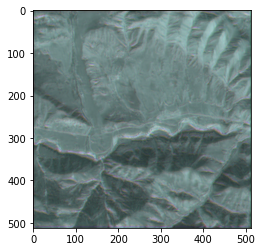

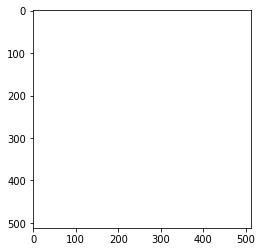

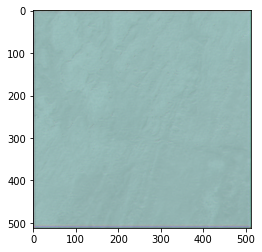

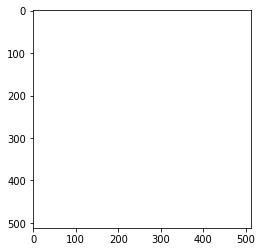

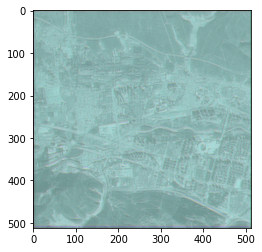

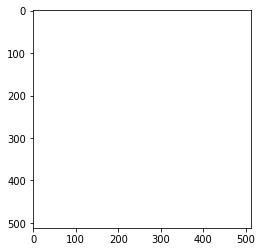

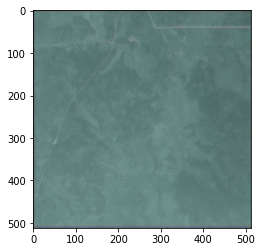

In [64]:
cloudypath = '/kaggle/input/spagaan/RICE_DATASET/RICE1/cloudy_image/'
testcd = [os.path.join(cloudypath,x) for x in trainlist]
for i in testcd[11:15]:
    im = cv2.imread(i)
    im = (im+1)/2
    plt.imshow(im)
    plt.show()
    im = im[np.newaxis, :, :, :]
    ts = g_model.predict(im)
    ts = np.squeeze(ts)
    ts = ts.astype('uint8')
    plt.imshow(cv2.cvtColor(ts,cv2.COLOR_BGR2RGB))
    #plt.imshow(ts)
    plt.show()

In [ ]:
traincloud = tf.data.Dataset.from_tensor_slices(traincloud)

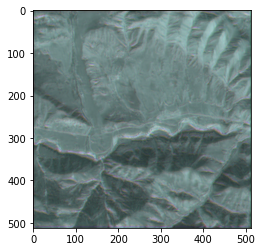

In [68]:
im = cv2.imread(testcd[11])

im =(im+1)/2.0
im = im[np.newaxis, :, :, :]
ik = g_model.predict(im)
ik = ik.astype('uint16')
ti = np.squeeze(ik)
ti = cv2.cvtColor(ti, cv2.COLOR_BGR2RGB)
plt.imshow(ti)

(<TensorSliceDataset shapes: (1, 512, 512, 3), types: tf.float32>,
 <TensorSliceDataset shapes: (1, 512, 512, 3), types: tf.float32>)

In [96]:
[a,b], c = generate_real_samples(dataset[10:20], 1, 1)

ValueError: not enough values to unpack (expected 2, got 0)

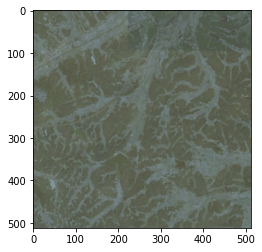

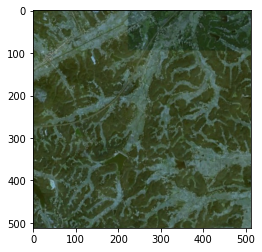

In [90]:
aa = tf.squeeze(a)
bb = tf.squeeze(b)
plt.imshow(aa)
plt.show()
plt.imshow(bb)
plt.show()

In [91]:
ff, gg = generate_fake_samples(g_model, a, 1)


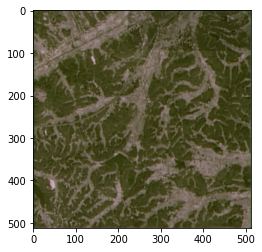

In [92]:
fff = tf.squeeze(ff)
plt.imshow(fff)

In [93]:
ssim3 = tf.image.ssim(bb, fff, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
loss = tf.keras.losses.mean_squared_error(bb, fff)
psnr2 = tf.image.psnr(bb, fff, max_val=1.0)

In [94]:
print(ssim3)
print(loss)
print(psnr2)

tf.Tensor(0.88255674, shape=(), dtype=float32)
tf.Tensor(
[[0.0095323  0.00217512 0.00205708 ... 0.00257565 0.00302648 0.01847617]
 [0.00587798 0.00998306 0.00302512 ... 0.00582503 0.00096314 0.01892471]
 [0.00667463 0.0082073  0.00113776 ... 0.0099388  0.00696147 0.00915528]
 ...
 [0.00890876 0.00037271 0.00300175 ... 0.00539094 0.00036906 0.00272612]
 [0.00520211 0.00649317 0.0060294  ... 0.00716887 0.00798094 0.02160535]
 [0.01507545 0.00117547 0.00149137 ... 0.00401585 0.02613754 0.05130975]], shape=(512, 512), dtype=float32)
tf.Tensor(24.48834, shape=(), dtype=float32)


In [82]:
l =tf.math.reduce_mean(
    loss, axis=None, keepdims=False, name=None
)

In [95]:
l

<tf.Tensor: shape=(), dtype=float32, numpy=0.0035576713>

AttributeError: 'NoneType' object has no attribute 'astype'

In [ ]:
def test(testdataloader, gen, cmse, epoch):
    avgmse = 0
    avgpsnr = 0
    avgssim = 0
    
    x = batch[0]
    t = batch[1]
    
    
    out = gen
    mse = cmse(out)
    psnr = 10 * np.log10(1 / mse.item())
    
    img1 = np.tensordot(out.transpose(1,2,0), [0.298912, 0.586611, 0.114478], axes =1)
    img2 = np.tensordot(t.transpose(1,2,0), [0.298912, 0.586611, 0.114478], axes =1)
    
    ssim = SSIM(img1, img2)
    avg_mse += mse.item()
    avg_psnr += psnr
    avg_ssim += ssim
    avg_mse = avg_mse / len(testdataloader)
    avg_psnr = avg_psnr / len(testdataloader)
    avg_ssim = avg_ssim / len(testdataloader)
    
    print("===> Avg. MSE: {:.4f}".format(avg_mse))
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr))
    print("===> Avg. SSIM: {:.4f} dB".format(avg_ssim))
    
    log_test = {}
    log_test['epoch'] = epoch
    log_test['mse'] = avg_mse
    log_test['psnr'] = avg_psnr
    log_test['ssim'] = avg_ssim
    
    return log_test

In [ ]:
def save_image(opdir, x, num, epoch, filename = None):
    test_dir = os.path.join(out_dir, 'epoch_{0.04d}'.format(epoch))
    if filename is not None:
        test_path = os.path.join(test_dir, filename)
    else:
        test_path = os.path.join(test_dir,'test_{0:04d}.png'.format(num) )
    
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    cv2.imwrite(test_path, x)

In [ ]:
def heatmap(img):
    if len(img.shape)==3:
        b.h.w = img.shape
        heat = np.zeros((b,3, h,w)).astype('unit8')
        for i in range(b):
            heat[i,:,:,:] = np.transpose(cv2.applyColorMap(img[i,:,:],cv2.COLORMAP_JET),(2,0,1))
    else:
        b,c,h,w = img.shape
        heat = np.zeros((b,3,h,w)).astype('uint8')
        for i in range(b):
            heat[i,:,:,:] = np.transpose(cv2.applyColorMap(img[i,0,:,:],cv2.COLORMAP_JET),(2,0,1))
    return heat

In [ ]:
def saveattasheatmap(filename,att):
    att_heat = heatmap(att)
    cv2.imwrite(filename, att_heat)
    print(filename, 'saved')

In [ ]:
def tf_dataset(x,y, batchs):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(datapreprocesstest)
    dataset = dataset.batch(batchs)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
def datapreprocesstest(c,g):
    tc = []
    tg = []
    fc = glob.glob(c)
    fg = glob.glob(g)
    for f1 in fc:
        Im =cv2.imread(str(c)).astype(np.float32)
        tc.append(Im)
    for f2 in fg:
        Ig = cv2.imread(str(g)).astype(np.float32)
        tg.append(Ig)    
    tc = tc/255
    tg = tg/255
    tc = tc.transpose(2,0,1)
    tg = tg.transpose(2,0,1)
    
    return tc, tg

In [ ]:
def datapreprocesstrain(c):
    trc = cv2.imread(c).astype(np.float32)
    trc = trc/255
    trc = trc.transpose(2,0,1)
    return trc

In [ ]:
trainsize = 0.8
validationsize = 0.2
dataset = train_dataset
trainsize = int(1 - validationsize * len(dataset))

In [ ]:
plt.imshow(pic)

In [ ]:
Ip = pic[np.newaxis, :, :, :]

In [ ]:
p = g_model.predict(Ip)

In [ ]:
npp = np.squeeze(p)
print(npp.shape)

In [ ]:
plt.imshow(npp)